In [35]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt


class Normal(object):
    def __init__(self, mu, sigma, log_sigma, v=None, r=None):
        self.mu = mu
        self.sigma = sigma  # either stdev diagonal itself, or stdev diagonal from decomposition
        self.logsigma = log_sigma
        dim = mu.get_shape()
        if v is None:
            v = torch.FloatTensor(*dim)
        if r is None:
            r = torch.FloatTensor(*dim)
        self.v = v
        self.r = r


class Encoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))


class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)
        # add convolutional layers

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))


class VAE(torch.nn.Module):

    def __init__(self, input_dim, latent_dim=8, H=100):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, H, H)
        self.decoder = Decoder(latent_dim, H, input_dim)
        self._enc_mu = torch.nn.Linear(H, latent_dim)
        self._enc_log_sigma = torch.nn.Linear(H, latent_dim)

    def _sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        mu = self._enc_mu(h_enc)
        log_sigma = self._enc_log_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()

        self.z_mean = mu
        self.z_sigma = sigma

        return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick

    def forward(self, state):
        h_enc = self.encoder(state)
        z = self._sample_latent(h_enc)
        return self.decoder(z)


def latent_loss(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)


In [73]:
from dataset import Dataset

batch_size = 16
patch_size = 64
input_dim = patch_size * patch_size

dataset = Dataset(patch_size=patch_size, stride=32, size=512, seed=1234)
dataloader = torch.utils.data.DataLoader(dataset=dataset, num_workers=1, batch_size=batch_size, shuffle=True)

print('Number of samples:', len(dataset))

vae = VAE(input_dim, latent_dim=32, H=200)

criterion = nn.MSELoss()

optimizer = optim.Adam(vae.parameters(), lr=0.000025)
l = None
for epoch in range(100):
    for i, data in enumerate(dataloader, 0):
        inputs = data[:,:,:,:,0]
        inputs = Variable(inputs.resize_(batch_size, input_dim))
        optimizer.zero_grad()
        dec = vae(inputs)
        ll = latent_loss(vae.z_mean, vae.z_sigma)
        loss = criterion(dec, inputs) + ll
        loss.backward()
        optimizer.step()
        l = loss.item()
    print(epoch, l)

Number of samples: 512
0 0.21379736065864563
1 0.1574878692626953
2 0.16685070097446442
3 0.1525840163230896
4 0.13977931439876556
5 0.12409774959087372
6 0.1095731183886528
7 0.10455337911844254
8 0.10042376071214676
9 0.10052473843097687
10 0.0792912021279335
11 0.08880199491977692
12 0.08172991126775742
13 0.0901094451546669
14 0.07618141174316406
15 0.0675208568572998
16 0.0737571269273758
17 0.07355763018131256
18 0.062221840023994446
19 0.07103846967220306
20 0.05763721093535423
21 0.07237588614225388
22 0.06339938938617706
23 0.06576217710971832
24 0.058876026421785355
25 0.07339071482419968
26 0.06606878340244293
27 0.06438542902469635
28 0.06909530609846115
29 0.053881462663412094
30 0.06488755345344543
31 0.06061321124434471
32 0.05015971511602402
33 0.06361892819404602
34 0.0409628227353096
35 0.054654933512210846
36 0.05425900220870972
37 0.05754680931568146
38 0.05054739490151405
39 0.06026695668697357
40 0.058200903236866
41 0.05271298065781593
42 0.058900222182273865
43 

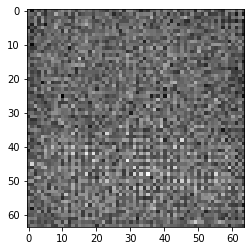

In [95]:
plt.imshow(vae(inputs).data[0].numpy().reshape(64, 64), cmap='gray')
plt.show(block=True)

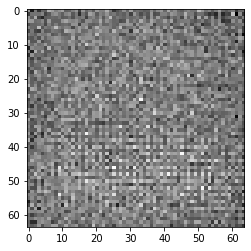

In [101]:
tmp = Variable(torch.from_numpy(np.random.normal(size=32)).float(), requires_grad=False)
img = vae.decoder(tmp)
plt.imshow(img.detach().numpy().reshape(64, 64), cmap='gray')